In [31]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import emcee
import gzip
import plotutils.runner as pr
import rates_tool.bf as bf
import rates_tool.foreground as fg
import rates_tool.kde as kde
import rates_tool.rate as rt
import triangle as tri
import scipy.optimize as so
import scipy.stats as ss

Populating the interactive namespace from numpy and matplotlib


The ``fore.dat.gz`` file contains simulated foreground in H and L drawn from an astrophysical population of CBC systems subject to the simulated detection threshold ($\rho > 5.5$ in both detectors).  The file is two-column in this case because the detection statistic is one-dimensional in each of two detectors, but $N_\mathrm{det}*N_\mathrm{stat}$ columns in the general case:

<table>
<tr><td>Detector 1, stat 1</td><td>Detector 1, stat 2</td><td> ... </td><td>Detector 2, stat 1</td><td>Detector 2, stat 2</td><td>...</td></tr>
<tr><td> ... </td><td> ... </td><td> ... </td><td> ... </td><td> ... </td><td> ... </td></tr>
</table>

Events in the coincident trigger set corresponding to this foreground population will be counted by the rates tool.

In [6]:
fore = loadtxt('fore.dat.gz')

In order to plot the foreground density, we will construct a KDE object.  (The rates tool will also do this auotmatically in the process of counting.)

In [7]:
fore_kde = kde.KDE(fore)

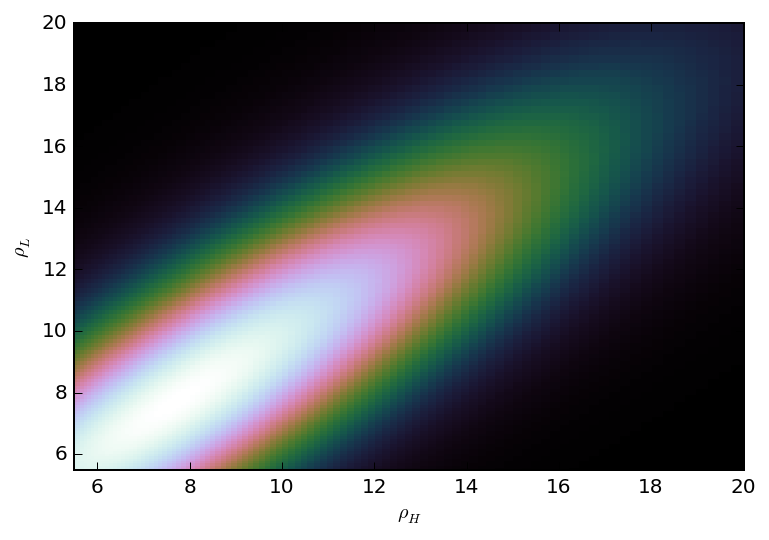

In [11]:
xs = exp(linspace(log(5.5), log(20), 100))
ys = exp(linspace(log(5.5), log(20), 100))
XS, YS = meshgrid(xs, ys)
log_ZS = fore_kde(column_stack((XS.flatten(), YS.flatten()))).reshape(XS.shape)
pcolormesh(XS, YS, exp(log_ZS))
xlabel(r'$\rho_H$')
ylabel(r'$\rho_L$')
axis(xmin=5.5, ymin=5.5)
savefig('fore.pdf')

The ``back-H.dat.gz`` and ``back-L.dat.gz`` files contain samples of the detection statistics from the individual detectors *not found in coincidence* during a simulated run, and therefore dominated by background.  (We ignore the small number of foreground signals that are above threshold in one detector but not in the other that contaminate this sample.)  In the general case, each such file would be composed of $N_\mathrm{stat}$ columns:

<table>
<tr><td>Stat 1</td><td>Stat 2</td><td>...</td></tr>
<tr><td>...</td><td>...</td><td>...</td></tr>
</table>

In [10]:
bgs = [loadtxt('back-H.dat.gz'), loadtxt('back-L.dat.gz')]

Plotting the joint distribution of the background events:

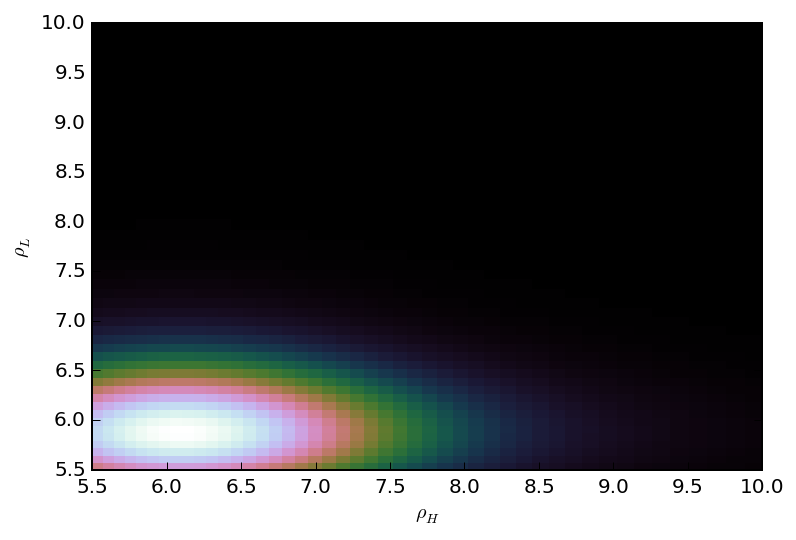

In [40]:
hkde = kde.KDE(bgs[0])
lkde = kde.KDE(bgs[1])

ZS = hkde(XS.flatten()) + lkde(YS.flatten())
ZS = ZS.reshape(XS.shape)
pcolormesh(XS, YS, exp(ZS))
xlabel(r'$\rho_H$')
ylabel(r'$\rho_L$')
axis(xmin=5.5, ymin=5.5, xmax=10, ymax=10)
savefig('back.pdf')

The final component required for the rates tool is a (usually small) list of the detection statistics of all the coincident triggers; this takes the same form as the foreground file, but involves coincs from the actual run.

In [43]:
coincs = loadtxt('coincs.dat.gz')

Construct the posterior object for sampling:

In [19]:
ratepost = rt.RatePosterior(bgs, fore, coincs)

We can optimise the posterior numerically, finding the MAP values of the foreground and background counts:

In [14]:
pbest = so.fmin_powell(lambda x: -ratepost(x), zeros(2))

Optimization terminated successfully.
         Current function value: -23.448405
         Iterations: 3
         Function evaluations: 80


It is most efficient to start sampling from the location of the MAP point; here we run until we have 128 decorrelated ensembles, each of 128 points, from the ``emcee`` sampler:

In [15]:
sampler = emcee.EnsembleSampler(128, 2, ratepost)
runner = pr.EnsembleSamplerRunner(sampler, pbest + 1e-3*randn(128, 2))
runner.run_to_neff(128)

Accumulated  128  ensembles, acceptance rate is  0.753601074219
Accumulated  256  ensembles, acceptance rate is  0.726593017578
Accumulated  384  ensembles, acceptance rate is  0.719095865885
Equivalent to  23  effective ensembles
Accumulated  512  ensembles, acceptance rate is  0.716018676758
Equivalent to  23  effective ensembles
Accumulated  640  ensembles, acceptance rate is  0.713610839844
Equivalent to  20  effective ensembles
Accumulated  768  ensembles, acceptance rate is  0.712219238281
Equivalent to  13  effective ensembles
Accumulated  896  ensembles, acceptance rate is  0.711966378348
Accumulated  1024  ensembles, acceptance rate is  0.711067199707
Equivalent to  11  effective ensembles
Accumulated  1152  ensembles, acceptance rate is  0.711317274306
Equivalent to  14  effective ensembles
Accumulated  1280  ensembles, acceptance rate is  0.710241699219
Equivalent to  17  effective ensembles
Accumulated  1408  ensembles, acceptance rate is  0.709822221236
Equivalent to  16  

Up to this point, we could have run the analysis using the tool ``rates.py`` which is automatically installed with the ``rates_tool`` package.  It will produce a pickled runner object, which, when loaded, will behave as our ``runner`` object.  See the help for ``rates.py`` for information on how to call the tool.

We can plot the posterior on the counts of foreground and background objects (note that the posterior is sampled in $\log R$ space, so we need to convert to $R$ for the plotting).  It doesn't look like there are very many foreground events in the data set:

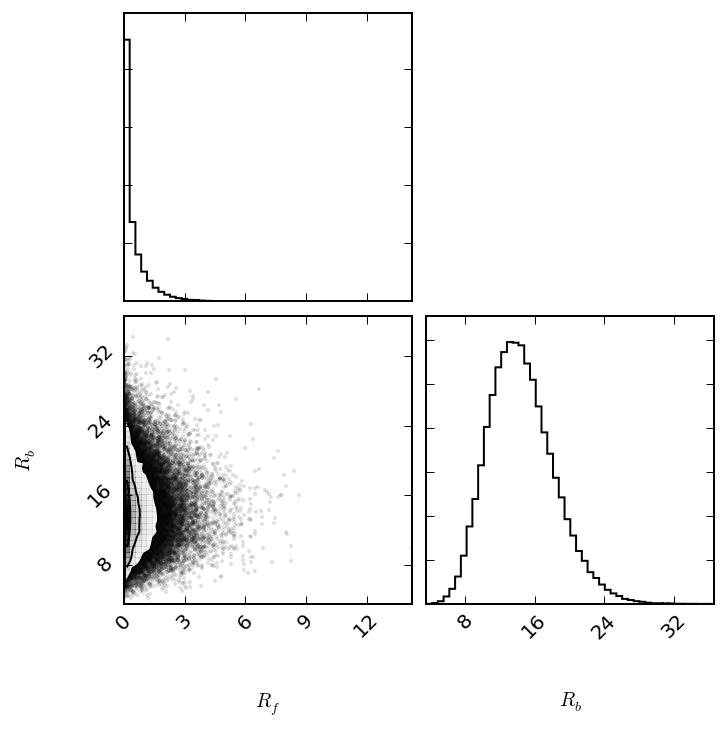

In [17]:
tri.corner(exp(runner.burnedin_chain.reshape((-1, 2))), labels=['$R_f$', r'$R_b$'])
savefig('rates.pdf')
None

We can also plot the posterior estimated foreground probability for each of the coincs.  The median value is the dot; bars give the 68% credible interval about the median.  As you can see, no event has a foreground probability greater than about $5\times 10^{-3}$.

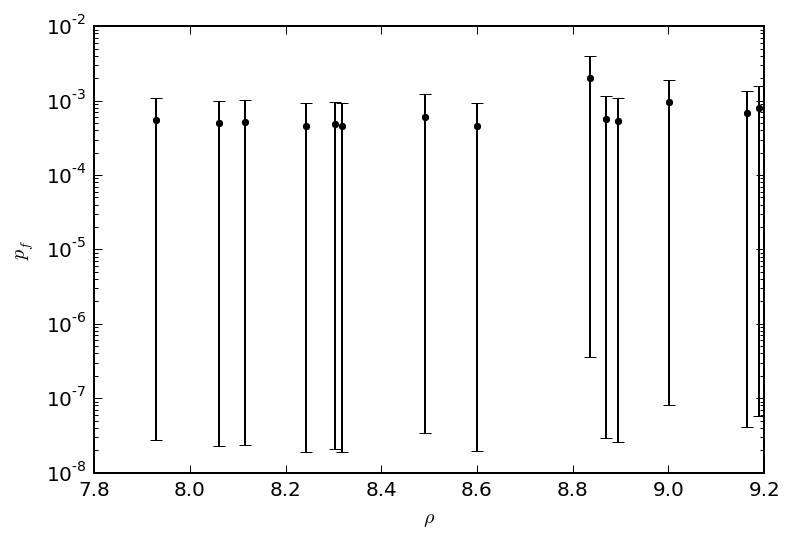

In [29]:
rhos = sqrt(np.sum(coincs*coincs, axis=1))
pfs = []
for p in runner.thin_flatchain:
    pfs.append(ratepost.log_pfores(p))
pfs = array(pfs)
errorbar(rhos, exp(median(pfs, axis=0)), exp((median(pfs, axis=0)) - exp(percentile(pfs, 16, axis=0)), exp(percentile(pfs, 84, axis=0))-exp(median(pfs, axis=0))), fmt='.', color='k')
yscale('log')
xlabel(r'$\rho$')
ylabel(r'$p_f$')
savefig('pfores.pdf')

We can also compute the Bayes factor between the model with foreground+background events versus the model with only background events; this is like a detection significance.  As expected, in this case, the Bayes factor favours the background-only model.

In [35]:
print 'log(BF) = ', bf.fore_back_log_bayes_factor(runner.thin_flatchain[:,0])[0]

log(BF) =  -2.24404741508


This was sort of boring, though, so what if we put some actual foreground events into the data?

In [44]:
fcoincs = concatenate((coincs, permutation(fore)[:10,:]), axis=0)

In [45]:
forepost = rt.RatePosterior(bgs, fore, fcoincs)

In [50]:
pbest = so.fmin_powell(lambda x: -forepost(x), zeros(2))

Optimization terminated successfully.
         Current function value: -8939.110624
         Iterations: 3
         Function evaluations: 84


In [51]:
sampler = emcee.EnsembleSampler(128, 2, forepost)
runner = pr.EnsembleSamplerRunner(sampler, pbest + 1e-3*randn(128, 2))
runner.run_to_neff(128)

Accumulated  128  ensembles, acceptance rate is  0.741821289062
Equivalent to  12  effective ensembles
Accumulated  256  ensembles, acceptance rate is  0.726013183594
Equivalent to  12  effective ensembles
Accumulated  384  ensembles, acceptance rate is  0.721435546875
Equivalent to  12  effective ensembles
Accumulated  512  ensembles, acceptance rate is  0.719589233398
Equivalent to  14  effective ensembles
Accumulated  640  ensembles, acceptance rate is  0.718481445313
Equivalent to  18  effective ensembles
Accumulated  768  ensembles, acceptance rate is  0.718332926432
Equivalent to  26  effective ensembles
Accumulated  896  ensembles, acceptance rate is  0.717398507254
Equivalent to  34  effective ensembles
Accumulated  1024  ensembles, acceptance rate is  0.715927124023
Equivalent to  24  effective ensembles
Accumulated  1152  ensembles, acceptance rate is  0.715705023872
Equivalent to  40  effective ensembles
Accumulated  1280  ensembles, acceptance rate is  0.715087890625
Equiva

Wow!  There are about 10 foreground signals in this data!

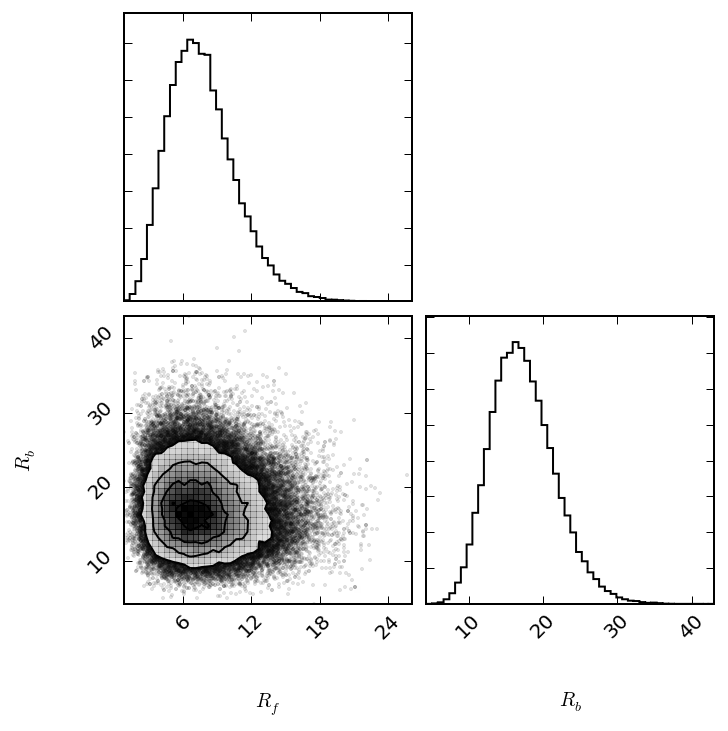

In [52]:
tri.corner(exp(runner.burnedin_chain.reshape((-1, 2))), labels=['$R_f$', r'$R_b$'])
savefig('frates.pdf')
None

Several of the coincs have virtual certainty to be foreground; here is the posterior background probability:

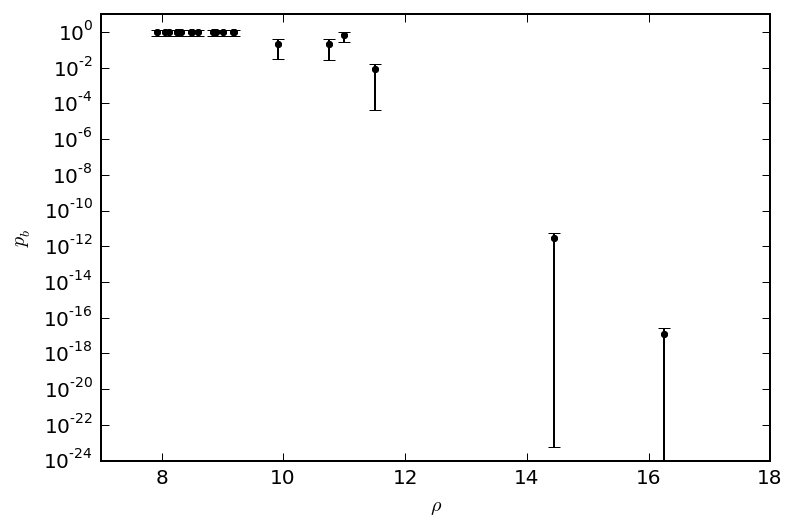

In [65]:
rhos = sqrt(np.sum(fcoincs*fcoincs, axis=1))
pbs = []
for p in runner.thin_flatchain:
    pbs.append(forepost.log_pbacks(p))
pbs = array(pbs)
errorbar(rhos, exp(median(pbs, axis=0)), exp((median(pbs, axis=0)) - exp(percentile(pbs, 16, axis=0)), exp(percentile(pfs, 84, axis=0))-exp(median(pfs, axis=0))), fmt='.', color='k')
yscale('log')
xlabel(r'$\rho$')
ylabel(r'$p_b$')
axis(xmin=7, xmax=18)
savefig('fpbacks.pdf')

In [60]:
print 'log(BF) = ', bf.fore_back_log_bayes_factor(runner.thin_flatchain[:,0])[0]

log(BF) =  4.54234465111
